# News API Data Collection

This document includes the steps to connect and import data from the the news api.

## Import Libraries

In [10]:
import pandas as pd
import requests
import json
import datetime
import time
import sqlite3
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from newsapi import NewsApiClient
import os
os.chdir('/Users/oanottage/Desktop/BTS/Data Science Foundations/DSFinal/')

import configparser
config = configparser.ConfigParser()
config.read('secrets/config.ini')

## Data Collection

In [11]:
#Function to preprocess source value from API
def extract_source_fields(row):
    source = row['source']
    source_id = source['id']
    source_name = source['name']
    return pd.Series({'source_id': source_id, 'source_name': source_name})

In [12]:
# Get today's date
today = datetime.datetime.today().date()
month_ago = today - datetime.timedelta(days=28)
# Print the date
print(today)
print(month_ago)

2023-03-09
2023-02-09


In [13]:
#Industry Label
industry = "artificial intelligence"
industry_csv = industry.replace(" ","_")
industry = industry.replace(" ", "&q=")

In [14]:
#API Connection
newsapi = NewsApiClient(api_key=config['DEFAULT']['news_api_key'])
all_articles = newsapi.get_everything(q=industry,
                                      from_param=month_ago,
                                      to=today,
                                      language='en',
                                      sort_by='popularity',
                                      page=1)
articles = all_articles['articles']
df = pd.DataFrame(articles)
df = df.reset_index()

In [15]:
# Apply the custom function to the 'source' column
df[['source_id', 'source_name']] = df.apply(extract_source_fields, axis=1)

In [16]:
# Use the pop() method to remove the 'source_id' and 'source_name' columns from the dataframe
source_id = df.pop('source_id')
source_name = df.pop('source_name')

# Use the insert() method to insert the 'source_id' and 'source_name' columns at the beginning of the dataframe
df.insert(0, 'source_id', source_id)
df.insert(1, 'source_name', source_name)

In [17]:
df.drop(columns=['source'],inplace=True)

In [18]:
df.head()

,source_id,source_name,index,author,title,description,url,urlToImage,publishedAt,content
0,business-insider,Business Insider,0,bevans@insider.com (Brian Evans),Charlie Munger says artificial intelligence is...,"""Artificial intelligence is very important, bu...",https://markets.businessinsider.com/news/stock...,https://i.insider.com/63ed4ad1dd6fcf00194a8e0a...,2023-02-15T21:33:22Z,Billionaire investor Charlie Munger said Wedne...
1,None,VentureBeat,1,Sri Krishna,Quantum Brilliance snags $18M funding on synth...,"Quantum Brilliance, which today announced an $...",https://venturebeat.com/programming-developmen...,https://venturebeat.com/wp-content/uploads/202...,2023-02-15T00:45:33Z,Quantum Brilliance hit the quantum computing s...
2,None,9to5Mac,2,Ben Lovejoy,Bing chatbot disasters: Why Apple isn’t jumpin...,If I’d asked the Bing chatbot to support our a...,https://9to5mac.com/2023/02/17/bing-chatbot-di...,https://i0.wp.com/9to5mac.com/wp-content/uploa...,2023-02-17T15:13:52Z,If I’d asked the Bing chatbot to support our a...
3,None,Phys.Org,3,Cathy Bussewitz,Insider Q&A: Satellite company fights climate ...,Finding and fixing methane leaks has been iden...,https://phys.org/news/2023-03-insider-qa-satel...,https://scx2.b-cdn.net/gfx/news/hires/2023/ins...,2023-03-06T13:47:18Z,Finding and fixing methane leaks has been iden...
4,bloomberg,Bloomberg,4,"Vildana Hajric, Michael P. Regan",How State Street Has Used AI to Find 'Hidden G...,"ChatGPT has taken the internet by storm, trigg...",https://www.bloomberg.com/news/articles/2023-0...,https://assets.bwbx.io/images/users/iqjWHBFdfx...,2023-02-11T19:06:43Z,"ChatGPT has taken the internet by storm, trigg..."


## Export API Data to CSV and SQLite

### CSV

In [19]:
df.to_csv(f'data/external/NewsAPI/{industry_csv}_articles_FROM_{month_ago}_TO_{today}.csv',index=False)

### SQLite

In [ ]:
df['TimeStamp'] = today

In [64]:
df.columns =['source_id', 'source_name', 'ind', 'author', 'title', 'description',
       'url', 'urlToImage', 'publishedAt', 'content', 'TimeStamp']

In [87]:
#Run the 'create if it doesn't exist' SQL statement
def create_db(folder,table_name, df):
    # Open a connection to the database and create a cursor
    cnx = sqlite3.connect(f'{folder}/DSFinal.db')
    c = cnx.cursor()

    # Get the column names and types from the dataframe
    cols = df.columns.tolist()
    types = df.dtypes.tolist()

    # Create the SQL CREATE TABLE statement
    create_statement = f"CREATE TABLE IF NOT EXISTS {table_name}({', '.join([f'{col} {type}' for col, type in zip(cols, types)])})"

    # Execute the CREATE TABLE statement
    c.execute(create_statement)

    # Commit the changes and close the cursor and connection
    cnx.commit()



#Creating the table
def create_table(folder,table_name, df):
    cnx = sqlite3.connect(f'{folder}/DSFinal.db')
    c = cnx.cursor()
    # Get the list of column names and data types in the DataFrame
    cols = list(df.columns)
    types = df.dtypes.apply(lambda x: x.name).tolist()
    
    # Create the CREATE TABLE statement dynamically
    create_statement = f"CREATE TABLE IF NOT EXISTS {table_name}({', '.join([f'{col} {type.upper()}' for col, type in zip(cols, types)])})"
    
    # Execute the CREATE TABLE statement
    c.execute(create_statement)
    # Commit the changes and close the cursor and connection
    cnx.commit()



#Dynamic Insertion
def dynamic_insertion(folder,table_name, df):
    cnx = sqlite3.connect(f'{folder}/DSFinal.db')
    c = cnx.cursor()
    # Get the list of column names in the DataFrame
    cols = list(df.columns)
    
    # Create the INSERT statement dynamically
    insert_statement = f"INSERT INTO {table_name}({', '.join(cols)}) VALUES ({', '.join(['?' for _ in range(len(cols))])})"
    
    # Insert the data into the database
    for index, row in df.iterrows():
        c.execute(insert_statement, tuple(row))
        cnx.commit()
    
    # Close the database connection and cursor
    c.close()
    cnx.close()

#Putting it all together
def push(folder,table_name, df):
  create_db(folder,table_name, df)
  create_table(folder,table_name,df)
  dynamic_insertion(folder,table_name,df)

In [80]:
push('databases','news_api',df)
push('databases','news_api',df)

## Wordcloud creation of Title, Description, and Content

### Title

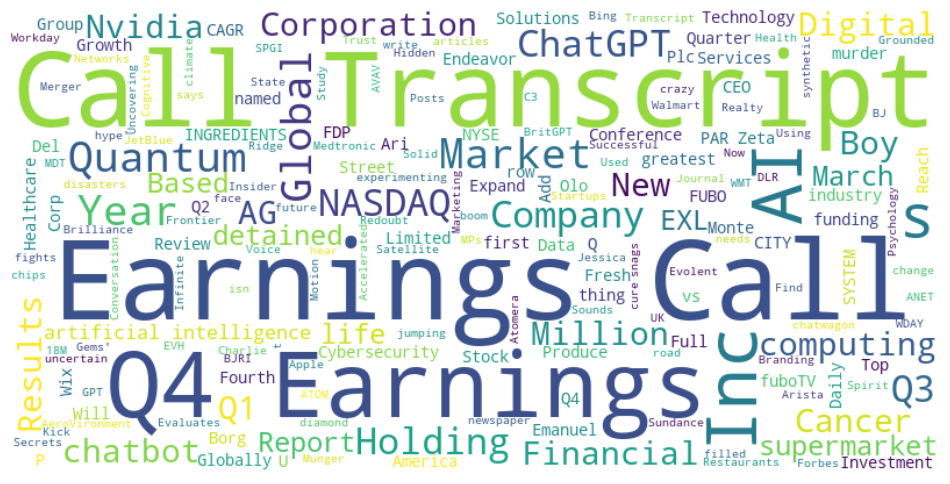

<Figure size 640x480 with 0 Axes>

In [20]:
#Create a wordcloud
# Extract the "title" column and combine all text into a single string
text = " ".join(df["title"].dropna())

# Create a WordCloud object with the desired parameters
wordcloud = WordCloud(width=800, height=400, max_words=200, background_color="white").generate(text)

# Display the WordCloud using Matplotlib
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

plt.savefig(f'media/{industry_csv}_by_title_{today}.png')

### Description

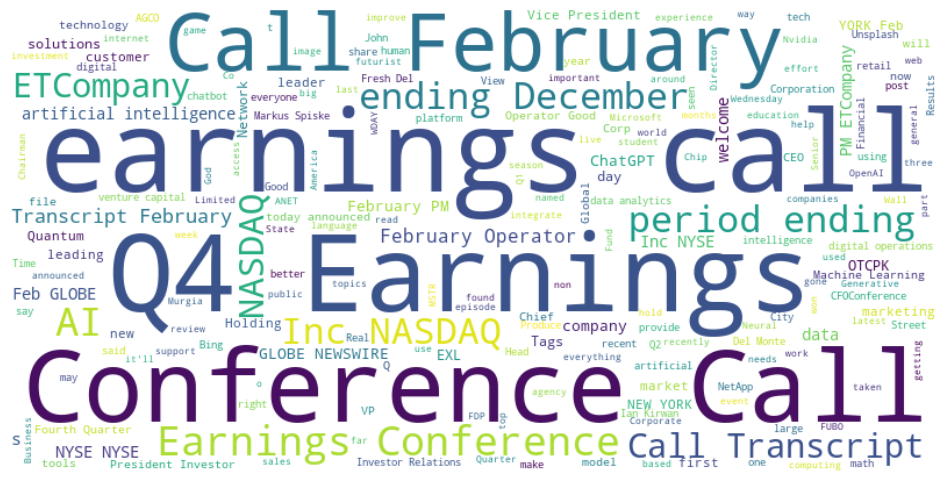

<Figure size 640x480 with 0 Axes>

In [44]:
#Create a wordcloud
# Extract the "description" column and combine all text into a single string
text = " ".join(df["description"].dropna())

# Create a WordCloud object with the desired parameters
wordcloud = WordCloud(width=800, height=400, max_words=200, background_color="white").generate(text)

# Display the WordCloud using Matplotlib
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
plt.savefig(f'media/{industry_csv}_by_description_{today}.png')

### Content

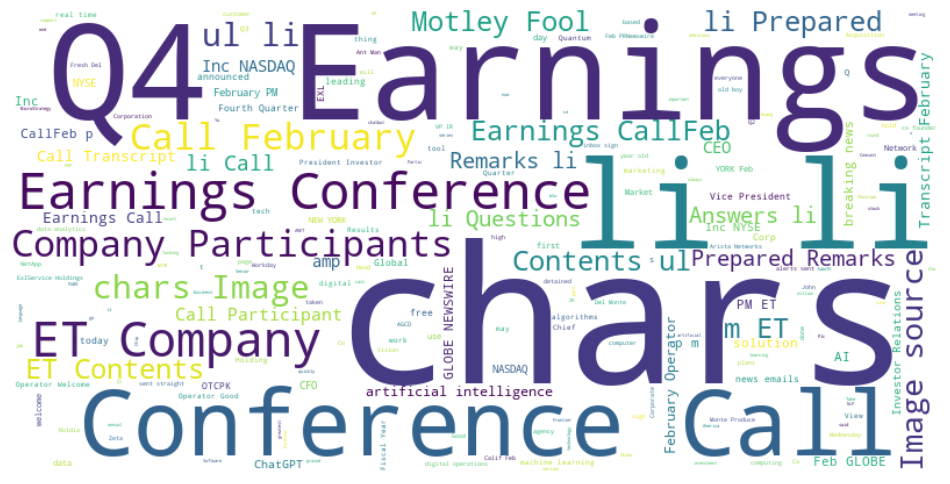

<Figure size 640x480 with 0 Axes>

In [45]:
#Create a wordcloud
# Extract the "content" column and combine all text into a single string
text = " ".join(df["content"].dropna())

# Create a WordCloud object with the desired parameters
wordcloud = WordCloud(width=800, height=400, max_words=200, background_color="white").generate(text)

# Display the WordCloud using Matplotlib
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
plt.savefig(f'media/{industry_csv}_by_content_{today}.png')